In [1]:
import numpy as np
import torch.nn as nn
import dynamic_selection as ds
import matplotlib.pyplot as plt
from torchmetrics import Accuracy, AUROC
from dynamic_selection import MaskingPretrainer, GreedyDynamicSelection

In [2]:
# Load dataset.
dataset = ds.data.load_spam()
d_in = dataset.input_size    # 57
d_out = dataset.output_size  # 2

# Normalize and split dataset.
mean = dataset.tensors[0].mean(dim=0)
dataset.tensors = (dataset.tensors[0] - mean, dataset.tensors[1])
train_dataset, val_dataset, test_dataset = ds.data.data_split(dataset)

In [3]:
# Set up networks
hidden = 128
dropout = 0.3

predictor = nn.Sequential(
    nn.Linear(2 * d_in, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_out))

selector = nn.Sequential(
    nn.Linear(2 * d_in, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_in))

In [4]:
# Pretrain predictor.
mask_layer = ds.utils.MaskLayer(append=True)
pretrain = MaskingPretrainer(predictor, mask_layer).cuda()
pretrain.fit(
    train_dataset,
    val_dataset,
    mbsize=128,
    lr=1e-3,
    nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

--------Epoch 1--------
Val loss = 0.8410

--------Epoch 2--------
Val loss = 0.6807

--------Epoch 3--------
Val loss = 0.6018

--------Epoch 4--------
Val loss = 0.6127

--------Epoch 5--------
Val loss = 0.6091

--------Epoch 6--------
Val loss = 0.5987

--------Epoch 7--------
Val loss = 0.5950

--------Epoch 8--------
Val loss = 0.5706

--------Epoch 9--------
Val loss = 0.5358

--------Epoch 10--------
Val loss = 0.4804

--------Epoch 11--------
Val loss = 0.4736

--------Epoch 12--------
Val loss = 0.4450

--------Epoch 13--------
Val loss = 0.4596

--------Epoch 14--------
Val loss = 0.4520

--------Epoch 15--------
Val loss = 0.4269

--------Epoch 16--------
Val loss = 0.4188

--------Epoch 17--------
Val loss = 0.4116

--------Epoch 18--------
Val loss = 0.4171

--------Epoch 19--------
Val loss = 0.4254

--------Epoch 20--------
Val loss = 0.4102

--------Epoch 21--------
Val loss = 0.3955

--------Epoch 22--------
Val loss = 0.4137

--------Epoch 23--------
Val loss = 0.409

In [5]:
# Train selector and predictor jointly.
gdfs = GreedyDynamicSelection(selector, predictor, mask_layer).cuda()
gdfs.fit(
    train_dataset,
    val_dataset,
    mbsize=128,
    lr=1e-3,
    nepochs=250,
    max_features=35,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

Starting training with temp = 1.0000

--------Epoch 1 (1 total)--------
Val loss = 0.3448, Zero-temp loss = 0.3547

--------Epoch 2 (2 total)--------
Val loss = 0.2948, Zero-temp loss = 0.3028

--------Epoch 3 (3 total)--------
Val loss = 0.2792, Zero-temp loss = 0.2886

--------Epoch 4 (4 total)--------
Val loss = 0.2722, Zero-temp loss = 0.2831

--------Epoch 5 (5 total)--------
Val loss = 0.2679, Zero-temp loss = 0.2778

--------Epoch 6 (6 total)--------
Val loss = 0.2605, Zero-temp loss = 0.2705

--------Epoch 7 (7 total)--------
Val loss = 0.2674, Zero-temp loss = 0.2783

--------Epoch 8 (8 total)--------
Val loss = 0.2539, Zero-temp loss = 0.2648

--------Epoch 9 (9 total)--------
Val loss = 0.2485, Zero-temp loss = 0.2602

--------Epoch 10 (10 total)--------
Val loss = 0.2449, Zero-temp loss = 0.2556

--------Epoch 11 (11 total)--------
Val loss = 0.2433, Zero-temp loss = 0.2545

--------Epoch 12 (12 total)--------
Val loss = 0.2361, Zero-temp loss = 0.2469

--------Epoch 13 (13

# Evaluate performance

- AUROC and top-1 accuracy increase quickly with the number of selections
- Performance can often be improved by increasing the `patience` parameter, or increasing the number of temperature steps (`temp_steps`)

In [6]:
# For saving results.
num_features = list(range(1, 11)) + list(range(15, 30, 5))
auroc_list = []
acc_list = []

# Metrics (softmax is applied automatically in recent versions of torchmetrics).
auroc_metric = lambda pred, y: AUROC(task='multiclass', num_classes=d_out)(pred.softmax(dim=1), y)
acc_metric = Accuracy(task='multiclass', num_classes=d_out)

# Evaluate.
for num in num_features:
    auroc, acc = gdfs.evaluate(test_dataset, num, (auroc_metric, acc_metric), 1024)
    auroc_list.append(auroc)
    acc_list.append(acc)
    print(f'Num = {num}, AUROC = {100*auroc:.2f}, Acc = {100*acc:.2f}')

Num = 1, AUROC = 82.88, Acc = 78.70
Num = 2, AUROC = 88.53, Acc = 81.63
Num = 3, AUROC = 91.83, Acc = 86.63
Num = 4, AUROC = 94.29, Acc = 88.59
Num = 5, AUROC = 95.00, Acc = 87.50
Num = 6, AUROC = 95.51, Acc = 88.26
Num = 7, AUROC = 95.97, Acc = 88.59
Num = 8, AUROC = 96.19, Acc = 90.54
Num = 9, AUROC = 96.48, Acc = 90.87
Num = 10, AUROC = 96.86, Acc = 91.63
Num = 15, AUROC = 97.73, Acc = 93.48
Num = 20, AUROC = 97.62, Acc = 93.15
Num = 25, AUROC = 98.00, Acc = 93.48


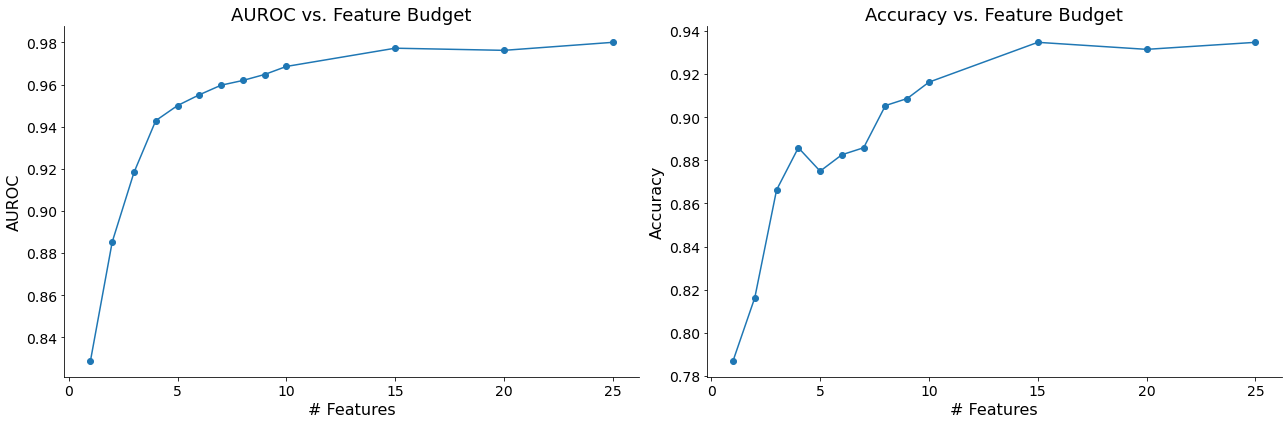

In [7]:
# Plot results
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))

# AUROC
plt.sca(axarr[0])
plt.plot(num_features, auroc_list, marker='o')
plt.xlabel('# Features', fontsize=16)
plt.ylabel('AUROC', fontsize=16)
plt.title('AUROC vs. Feature Budget', fontsize=18)
plt.tick_params(labelsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Accuracy
plt.sca(axarr[1])
plt.plot(num_features, acc_list, marker='o')
plt.xlabel('# Features', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy vs. Feature Budget', fontsize=18)
plt.tick_params(labelsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

# Plot selections

In [8]:
# Generate selections for entire test set.
num_features = range(1, 26)
p_list = []
for num in num_features:
    x, y = ds.data.get_xy(test_dataset)
    pred, x_masked, m = gdfs(x.cuda(), max_features=num)
    p = m.mean(dim=0)
    p_list.append(p.cpu().numpy())

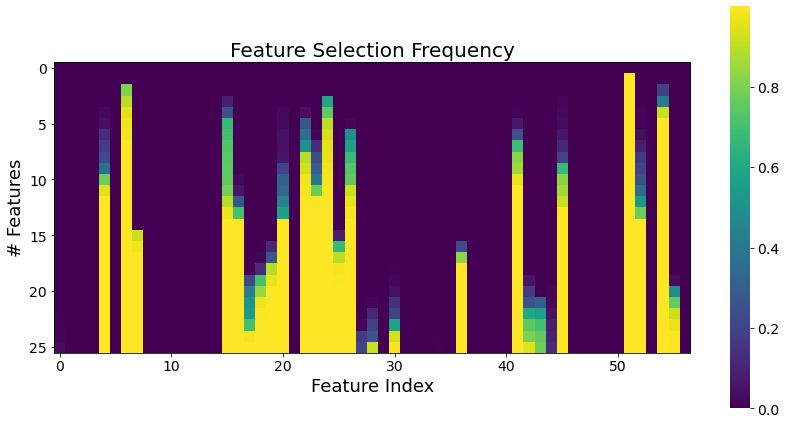

In [9]:
plt.figure(figsize=(12, 6))

# Plot heatmap.
heatmap = np.stack([np.zeros(len(p_list[0]))] + p_list)
plt.imshow(heatmap, cmap='viridis')

# Labels.
plt.xlabel('Feature Index', fontsize=18)
plt.ylabel('# Features', fontsize=18)
plt.title('Feature Selection Frequency', fontsize=20)
plt.tick_params(labelsize=14)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.outline.set_visible(False)

plt.tight_layout()
plt.show()